In [1]:
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
import plotly.express as px
import scipy as sp
from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import os
import tqdm as tqdm
import warnings

2023-08-25 22:17:41.168282: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-25 22:17:41.184056: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-25 22:17:41.361169: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-25 22:17:41.362914: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 22:17:43.426651: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
path = 'weed_data/agri_data/'

In [3]:
df=pd.read_csv('weed_data/agri_label.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2072 non-null   object
 1   width     2072 non-null   int64 
 2   height    2072 non-null   int64 
 3   class     2072 non-null   object
 4   xmin      2072 non-null   int64 
 5   ymin      2072 non-null   int64 
 6   xmax      2072 non-null   int64 
 7   ymax      2072 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 129.6+ KB


In [4]:
folder_images = os.listdir(path)
len(folder_images)

3900

In [5]:
train_images = folder_images[:1000]
test_images = folder_images[1000:]

In [6]:
crop_folder = './weed_data/crop/'
weed_folder = './weed_data/weed/'

for _,row in df.iterrows():
    filename = row['filename']
    label = row['class']
    
    og_image_path = os.path.join(path,filename)
    if label=="crop":
        shutil.copy(og_image_path,os.path.join(crop_folder,filename))
    elif label=="weed":
        shutil.copy(og_image_path,os.path.join(weed_folder,filename))

class_names = ["weed","crop"]    
n_weed = len(os.listdir(weed_folder))
n_crop = len(os.listdir(crop_folder))
n_images = [n_weed,n_crop]
px.pie(names=class_names,values=n_images)


/home/the_architect/DL_MODEL/weed binary classifier 


In [7]:
cwd=os.getcwd()
base_dir = os.path.join(cwd,'weed_data')
sub_dirs=['training','test','validation']
classes=["weed","crop"]

try:
    for sub_dir in sub_dirs:
        os.mkdir(os.path.join(base_dir,sub_dir))
        for class_name in classes:
            os.mkdir(os.path.join(base_dir,sub_dir,class_name))
except OSError as e:
    print("Error failed to make directory")
    print(e)
    

In [8]:
def split_data(main_dir,training_dir,validation_dir,test_dir=None,include_test_split=True,split_size=0.9):
    files=[file for file in os.listdir(main_dir)]
    for file in os.listdir(main_dir):
        if os.path.getsize(os.path.join(main_dir,file)):
            files.append(file)
    shuffled_files = random.sample(files,len(files))
    split=int(0.9*len(shuffled_files))
    train=shuffled_files[:split]
    split_valid_test=int(split+(len(shuffled_files)-split)/2)
    
    if include_test_split:
        validation = shuffled_files[split:split_valid_test]
        test=shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]
    
    for element in train:
        copyfile(os.path.join(main_dir,element),os.path.join(training_dir,element))
    for element in validation:
        copyfile(os.path.join(main_dir,element),os.path.join(validation_dir,element))
    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir,element),os.path.join(test_dir,element))
    print("Split Successful")

In [9]:
WEED_DIR='./weed_data/weed/'
CROP_DIR='./weed_data/crop/'
TRAINING_DIR='./weed_data/training/'
VALIDATION_DIR='./weed_data/validation/'
TEST_DIR = './weed_data/test/'

TRAINING_WEED = os.path.join(TRAINING_DIR, "weed/")
VALIDATION_WEED = os.path.join(VALIDATION_DIR, "weed/")
TEST_WEED = os.path.join(TEST_DIR,'weed/')

TRAINING_CROP = os.path.join(TRAINING_DIR, "crop/")
VALIDATION_CROP = os.path.join(VALIDATION_DIR, "crop/")
TEST_CROP =os.path.join(TEST_DIR,'crop/')

INCLUDE_TEST=True


In [10]:
split_data(WEED_DIR,TRAINING_WEED,VALIDATION_WEED,TEST_WEED,INCLUDE_TEST, 0.9)
split_data(CROP_DIR,TRAINING_CROP,VALIDATION_CROP,TEST_CROP,INCLUDE_TEST, 0.9)

Split Successful
Split Successful


In [11]:
print(len(TRAINING_CROP))
print(len(TRAINING_WEED))

print(len(TEST_CROP))
print(len(TEST_WEED))

print(len(VALIDATION_CROP))
print(len(VALIDATION_WEED))

26
26
22
22
28
28


In [12]:
train_gen = ImageDataGenerator(
        rescale=1./255)


validation_gen =  ImageDataGenerator(
        rescale=1./255.)

if INCLUDE_TEST:
    test_gen =  ImageDataGenerator(
            rescale=1./255.)


In [13]:
train_generator = train_gen.flow_from_directory(
        './weed_data/training/',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')
validation_generator = validation_gen.flow_from_directory(
        './weed_data/validation/',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

if INCLUDE_TEST:
    test_generator = test_gen.flow_from_directory(
        './weed_data/validation/',
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 1284 images belonging to 2 classes.


Found 124 images belonging to 2 classes.
Found 124 images belonging to 2 classes.


In [14]:
class_names = ['WEED', 'CROP']
def plot_data(generator, n_images):
    """
    Plots random data from dataset
    Args:
    generator: a generator instance
    n_images : number of images to plot
    """
    i = 1
    images, labels = generator.next()
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == n_images:
            break
    
    plt.show()

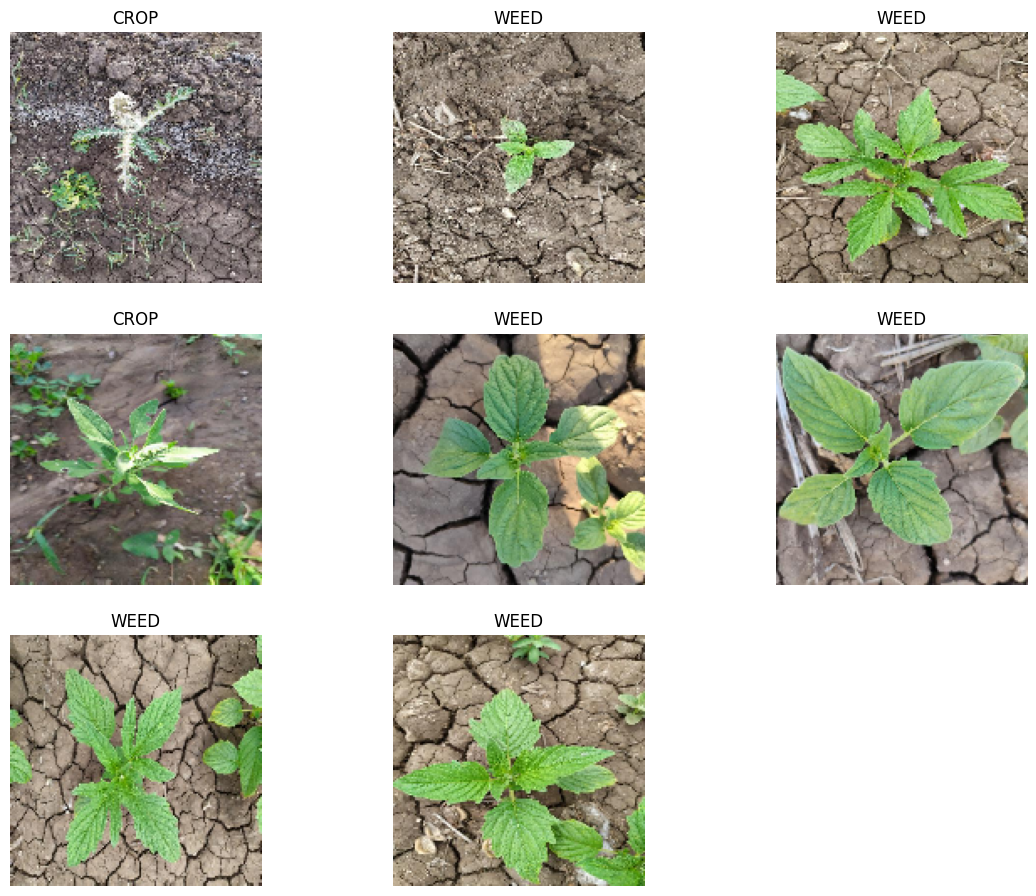

In [15]:
plot_data(train_generator,9)

In [16]:
train_gen_aug = ImageDataGenerator(
        rescale=1./255,fill_mode='nearest',horizontal_flip=True,
        rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)


validation_gen_aug =  ImageDataGenerator(
        rescale=1./255.)


In [17]:
train_generator = train_gen_aug.flow_from_directory(
        './weed_data/training',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
validation_generator = validation_gen_aug.flow_from_directory(
        './weed_data/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 1284 images belonging to 2 classes.
Found 124 images belonging to 2 classes.


In [18]:
inputs = tf.keras.layers.Input(shape=(150,150,3))
x =  tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)


x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x) 
x = tf.keras.layers.Dense(2, activation='softmax')(x) 

model_aug = Model(inputs=inputs, outputs=x)

In [19]:
model_aug.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [20]:
r = model_aug.fit(
        train_generator,
        epochs=40,
        validation_data=validation_generator)

Epoch 1/40
41/41 [==============================] - 97s 2s/step - loss: 0.9846 - accuracy: 0.5343 - val_loss: 0.7030 - val_accuracy: 0.4839
Epoch 2/40
41/41 [==============================] - 96s 2s/step - loss: 0.6942 - accuracy: 0.5234 - val_loss: 0.6918 - val_accuracy: 0.5161
Epoch 3/40
41/41 [==============================] - 98s 2s/step - loss: 0.6936 - accuracy: 0.5195 - val_loss: 0.6901 - val_accuracy: 0.7742
Epoch 4/40
41/41 [==============================] - 97s 2s/step - loss: 0.8484 - accuracy: 0.5826 - val_loss: 0.5802 - val_accuracy: 0.7500
Epoch 5/40
41/41 [==============================] - 99s 2s/step - loss: 0.6942 - accuracy: 0.6495 - val_loss: 0.5236 - val_accuracy: 0.7903
Epoch 6/40
41/41 [==============================] - 99s 2s/step - loss: 0.5816 - accuracy: 0.7687 - val_loss: 0.5678 - val_accuracy: 0.7500
Epoch 7/40
41/41 [==============================] - 97s 2s/step - loss: 0.4738 - accuracy: 0.8139 - val_loss: 0.5565 - val_accuracy: 0.6935
Epoch 8/40
41/41 [==

In [21]:
results = pd.DataFrame(r.history)
results.tail()

,loss,accuracy,val_loss,val_accuracy
35,0.254362,0.914330,0.259811,0.895161
36,0.250786,0.908879,0.440588,0.870968
37,0.241554,0.920561,0.785532,0.782258
38,0.247569,0.913551,0.695488,0.822581
39,0.244730,0.917445,0.240146,0.943548


In [22]:
fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(   
    title_font_color="#fad25a", 
    xaxis=dict(color="#fad25a",title='Epochs'), 
    yaxis=dict(color="#fad25a")
 )
fig.show()

In [23]:
fig = px.line(results,y=[results['loss'],results['val_loss']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(   
    title_font_color="#fad25a", 
    xaxis=dict(color="#fad25a",title='Epochs'), 
    yaxis=dict(color="#fad25a")
 )
fig.show()

In [24]:
model_aug.save("./assets/weed_model.h5")
model_aug.save("./assets/weed_model.keras")

/home/the_architect/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [2]:
new_model = tf.keras.models.load_model("./assets/weed_model.h5")

In [10]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 128)       73856     
                                                             

In [30]:
def image_show(img_array,class_class,color_selector):
    img_array = img_array.squeeze()
    plt.figure(figsize=(14, 15))
    plt.subplot(4, 3, 1)
    plt.imshow(img_array)
    plt.title("Predicted class:"+class_class,color = color_selector)
    plt.axis('off')
    plt.show()

['agri_0_3230.jpeg', 'agri_0_5819.jpeg', 'agri_0_9871.jpeg', 'agri_0_4519.jpeg', 'agri_0_5625.jpeg', 'agri_0_7517.jpeg', 'agri_0_1177.jpeg', 'agri_0_920.jpeg', 'agri_0_744.jpeg', 'agri_0_7141.jpeg', 'agri_0_6801.jpeg', 'agri_0_866.jpeg', 'agri_0_4499.jpeg', 'agri_0_495.jpeg', 'agri_0_5733.jpeg', 'agri_0_131.jpeg', 'agri_0_935.jpeg', 'agri_0_6417.jpeg', 'agri_0_4218.jpeg', 'agri_0_6039.jpeg', 'agri_0_8246.jpeg', 'agri_0_8478.jpeg', 'agri_0_6831.jpeg', 'agri_0_9888.jpeg', 'agri_0_6270.jpeg', 'agri_0_3152.jpeg', 'agri_0_8482.jpeg', 'agri_0_8959.jpeg', 'agri_0_2639.jpeg', 'agri_0_2808.jpeg', 'agri_0_2077.jpeg', 'agri_0_3160.jpeg', 'agri_0_2441.jpeg', 'agri_0_4301.jpeg', 'agri_0_2221.jpeg', 'agri_0_544.jpeg', 'agri_0_4058.jpeg', 'agri_0_7294.jpeg', 'agri_0_3964.jpeg', 'agri_0_1123.jpeg', 'agri_0_7034.jpeg', 'agri_0_2484.jpeg', 'agri_0_1929.jpeg', 'agri_0_6412.jpeg', 'agri_0_5780.jpeg', 'agri_0_6572.jpeg', 'agri_0_8893.jpeg', 'agri_0_2088.jpeg', 'agri_0_1026.jpeg', 'agri_0_318.jpeg', 'agri_0

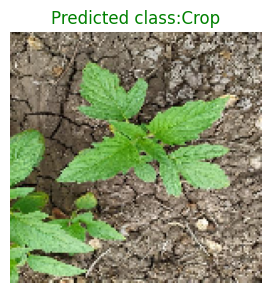

Image path: ./weed_data/validation/weed/agri_0_5458.jpeg
1/1 [==============================] - 0s 114ms/step
Weed


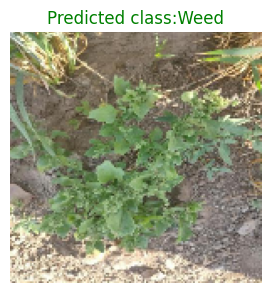

Image path: ./weed_data/validation/weed/agri_0_4617.jpeg
1/1 [==============================] - 0s 94ms/step
Weed


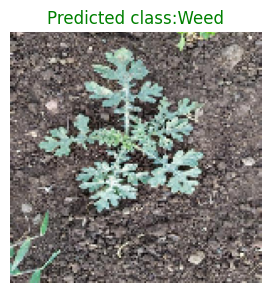

Image path: ./weed_data/validation/crop/agri_0_8482.jpeg
1/1 [==============================] - 0s 85ms/step
Crop


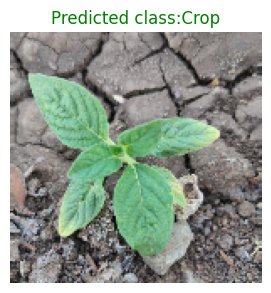

Image path: ./weed_data/validation/crop/agri_0_1123.jpeg
1/1 [==============================] - 0s 64ms/step
Crop


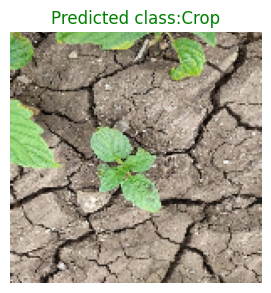

Image path: ./weed_data/validation/weed/agri_0_4617.jpeg
1/1 [==============================] - 0s 85ms/step
Weed


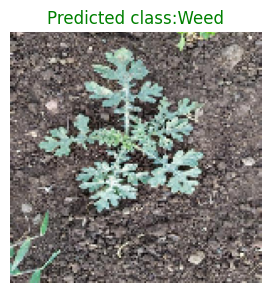

Image path: ./weed_data/validation/crop/agri_0_2077.jpeg
1/1 [==============================] - 0s 99ms/step
Crop


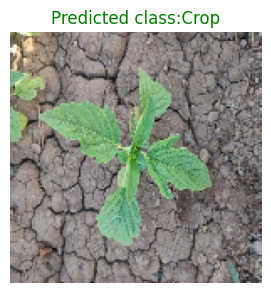

Image path: ./weed_data/validation/weed/agri_0_909.jpeg
1/1 [==============================] - 0s 80ms/step
Weed


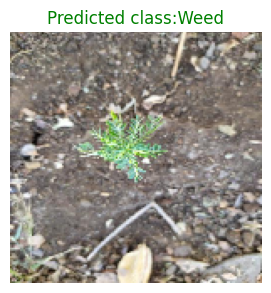

Image path: ./weed_data/validation/crop/agri_0_4499.jpeg
1/1 [==============================] - 0s 84ms/step
Crop


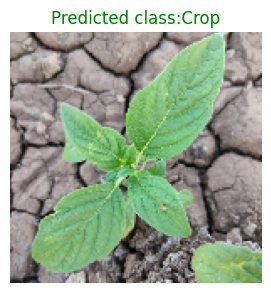

Image path: ./weed_data/validation/crop/agri_0_318.jpeg
1/1 [==============================] - 0s 81ms/step
Crop


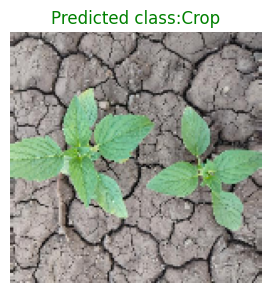

In [31]:
CROP_VALIDATION = "./weed_data/validation/crop/"
WEED_VALIDATION = "./weed_data/validation/weed/"

crop_files = os.listdir(CROP_VALIDATION)
weed_files = os.listdir(WEED_VALIDATION)



print(crop_files)

n = 10
for i in range(n):
    class_selector = random.randint(0, 1)
    if class_selector == 0:
        random_index = random.randint(0, len(crop_files) - 1)
        image_path = os.path.join(CROP_VALIDATION, crop_files[random_index])
    else:
        random_index = random.randint(0, len(weed_files) - 1)
        image_path = os.path.join(WEED_VALIDATION, weed_files[random_index])

    print("Image path:", image_path)
    img = image.load_img(image_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    prediction = new_model.predict(img_array)
    predicted_class = np.argmax(prediction)
    color_selector = "green" if predicted_class == class_selector else "red" 
    if predicted_class == 0:
        class_class = "Crop"
        print("Crop")
        image_show(img_array,class_class,color_selector) 
    else:
        class_class = "Weed"
        print("Weed")
        image_show(img_array,class_class,color_selector)


In [5]:
prediction = new_model.predict(img_array)
predicted_class = np.argmax(prediction)  # Get the index of the class with highest probability
if (predicted_class == 0):
    class_class="Crop"
    print("Crop")
else:
    class_class="Weed"
    print("Weed")

img_array=img_array.squeeze()    
plt.imshow(img_array)
plt.title("Predicted class:"+class_class)
plt.show    




: 

: 